In [ ]:
# prompt: mount the folder in which the ipynb is located

import os
from google.colab import drive

drive.mount('/content/drive')

# Get the current working directory
# current_directory = os.getcwd()

%cd ./drive/MyDrive/DeepL_BI_codes/project/

# Verify the change
print(f"Current working directory: {os.getcwd()}")


In [ ]:
# prompt: unzip original files.zip

# !unzip OriginalFiles.zip > /dev/null


In [ ]:
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import os
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings(action="ignore")

# Inline plotting (optional in Colab, but safe to include)
%matplotlib inline

# TensorFlow/Keras and model components
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

# Learning rate schedule
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
# Define the base directory where AugmentedAlzheimerDataset is located
base_dir = os.path.join("AugmentedAlzheimerDataset")
# base_dir = os.path.join("data", "OriginalDataset")

# Define paths for each category
mild_demented_path = os.path.join(base_dir, "MildDemented")
moderate_demented_path = os.path.join(base_dir, "ModerateDemented")
non_demented_path = os.path.join(base_dir, "NonDemented")
very_mild_demented_path = os.path.join(base_dir, "VeryMildDemented")

# Create variables with lists of image file paths for each category
mild_demented_images = glob(os.path.join(mild_demented_path, "*"))
moderate_demented_images = glob(os.path.join(moderate_demented_path, "*"))
non_demented_images = glob(os.path.join(non_demented_path, "*"))
very_mild_demented_images = glob(os.path.join(very_mild_demented_path, "*"))

# Optionally, print the number of images found in each folder
print("Mild Demented:", len(mild_demented_images))
print("Moderate Demented:", len(moderate_demented_images))
print("Non Demented:", len(non_demented_images))
print("Very Mild Demented:", len(very_mild_demented_images))

In [ ]:
data = []

data.extend([(img, "MildDemented") for img in mild_demented_images])
data.extend([(img, "ModerateDemented") for img in moderate_demented_images])
data.extend([(img, "NonDemented") for img in non_demented_images])
data.extend([(img, "VeryMildDemented") for img in very_mild_demented_images])

print("Total images:", len(data))

In [ ]:
# Define the four categories
categories = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

# For each category, select the first image found in data
samples = {cat: next(img for img, label in data if label == cat) for cat in categories}

plt.figure(figsize=(12, 4))
for i, cat in enumerate(categories):
    # Open the image and plot it
    img = Image.open(samples[cat])
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(cat)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Create DataFrame
df = pd.DataFrame(data, columns=['filepaths', 'labels'])

# Shuffle the full dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Define how many samples you want
num_train_samples = 5000   # Total samples used for train + val
num_test_samples = 1000     # Total samples used for test

# Check total is within dataset size
assert num_train_samples + num_test_samples <= len(df), \
    "Requested train + test size exceeds dataset size."

# Step 1: Sample training subset (stratified)
train_val_subset = df.groupby('labels', group_keys=False).apply(
    lambda x: x.sample(int(num_train_samples * len(x) / len(df)), random_state=42)
).reset_index(drop=True)

# Step 2: Remove train_val samples from df and sample test set (stratified)
remaining = df.drop(train_val_subset.index).reset_index(drop=True)
test_images = remaining.groupby('labels', group_keys=False).apply(
    lambda x: x.sample(int(num_test_samples * len(x) / len(df)), random_state=42)
).reset_index(drop=True)

# Step 3: Split training subset into train and validation sets (e.g., 80/20)
train_set, val_set = train_test_split(
    train_val_subset,
    test_size=0.2,
    random_state=42,
    stratify=train_val_subset['labels']
)

# Print final shapes
print("Train set:", train_set.shape)
print("Validation set:", val_set.shape)
print("Test set:", test_images.shape)

In [ ]:
# Use MobileNetV2 preprocessing and set up data generators
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Training data generator
train = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=True  # Can set to True for training
)

# Validation data generator
val = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

# Testing data generator
test = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(244, 244),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 3999 validated image filenames belonging to 4 classes.
Found 1000 validated image filenames belonging to 4 classes.
Found 836 validated image filenames belonging to 4 classes.


# EfficientNetB7

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB7

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB7 model without the top classification layer
base_model = EfficientNetB7(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB7_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB7_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB7_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,426,011 (245.77 MB)

 Trainable params: 51,795,452 (197.58 MB)

 Non-trainable params: 12,630,559 (48.18 MB)

In [ ]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [ ]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB7_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2287s 17s/step - accuracy: 0.3769 - loss: 2.7579 - val_accuracy: 0.4240 - val_loss: 1.1981 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 594ms/step - accuracy: 0.5733 - loss: 0.9807 - val_accuracy: 0.6410 - val_loss: 0.8224 - learning_rate: 9.5000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 582ms/step - accuracy: 0.6259 - loss: 0.8350 - val_accuracy: 0.6830 - val_loss: 0.7204 - learning_rate: 9.0250e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 577ms/step - accuracy: 0.6697 - loss: 0.7665 - val_accuracy: 0.7260 - val_loss: 0.6395 - learning_rate: 8.5737e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 577ms/step - accuracy: 0.7024 - loss: 0.6668 - val_accuracy: 0.7220 - val_loss: 0.6053 - learning_rate: 8.1451e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 579ms/step - accuracy: 0.7526 - loss: 0.6019 - val_accuracy: 0.7420 - val_loss: 0.6047 - learning_rate: 7.7378e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 579ms/

In [ ]:
train_loss, train_accuracy =  EfficientNetB7_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB7_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB7_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - accuracy: 0.9506 - loss: 0.1483

Train loss: 0.15
Train Accuracy: 94.80 %
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - accuracy: 0.8625 - loss: 0.3995

validation loss: 0.43
Validation Accuracy: 84.50 %
27/27 ━━━━━━━━━━━━━━━━━━━━ 283s 11s/step - accuracy: 0.9315 - loss: 0.2225

test loss: 0.42
test Accuracy: 85.65 %


In [ ]:
result = EfficientNetB7_model.evaluate(test, verbose=1)
print(result)

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.9315 - loss: 0.2225
[0.4164763391017914, 0.8564593195915222]


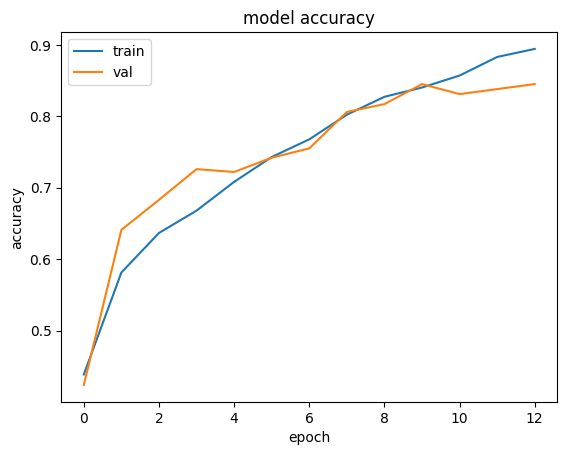

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

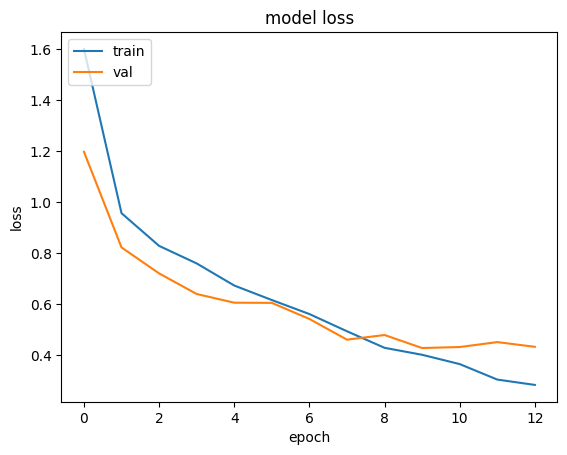

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB7_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 899ms/step
                  precision    recall  f1-score   support

    MildDemented       0.86      0.94      0.90       244
ModerateDemented       0.95      0.99      0.97       168
     NonDemented       0.80      0.92      0.85       261
VeryMildDemented       0.85      0.50      0.63       163

        accuracy                           0.86       836
       macro avg       0.87      0.84      0.84       836
    weighted avg       0.86      0.86      0.85       836

Accuracy of the Model: 85.6%


# EfficientNetB6

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB6

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB6 model without the top classification layer
base_model = EfficientNetB6(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

165234480/165234480 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB6_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB6_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB6_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb6 (Functional)     │ (None, 2304)           │    40,960,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,255,699 (157.38 MB)

 Trainable params: 33,150,808 (126.46 MB)

 Non-trainable params: 8,104,891 (30.92 MB)

In [ ]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [ ]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB6_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 228s 986ms/step - accuracy: 0.3782 - loss: 2.4944 - val_accuracy: 0.4530 - val_loss: 1.2238 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 405ms/step - accuracy: 0.5738 - loss: 0.9501 - val_accuracy: 0.6320 - val_loss: 0.8170 - learning_rate: 9.5000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 414ms/step - accuracy: 0.6401 - loss: 0.8148 - val_accuracy: 0.6800 - val_loss: 0.7145 - learning_rate: 9.0250e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 445ms/step - accuracy: 0.6708 - loss: 0.7406 - val_accuracy: 0.7300 - val_loss: 0.6272 - learning_rate: 8.5737e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 419ms/step - accuracy: 0.7003 - loss: 0.6862 - val_accuracy: 0.7620 - val_loss: 0.5670 - learning_rate: 8.1451e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - accuracy: 0.7467 - loss: 0.5828 - val_accuracy: 0.7520 - val_loss: 0.5907 - learning_rate: 7.7378e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 420ms

In [ ]:
train_loss, train_accuracy =  EfficientNetB6_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB6_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB6_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 269ms/step - accuracy: 0.9832 - loss: 0.0557

Train loss: 0.05
Train Accuracy: 98.50 %
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.8755 - loss: 0.3648

validation loss: 0.38
Validation Accuracy: 87.00 %
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 495ms/step - accuracy: 0.9423 - loss: 0.1845

test loss: 0.35
test Accuracy: 88.64 %


In [ ]:
result = EfficientNetB6_model.evaluate(test, verbose=1)
print(result)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.9423 - loss: 0.1845
[0.35138556361198425, 0.8863636255264282]


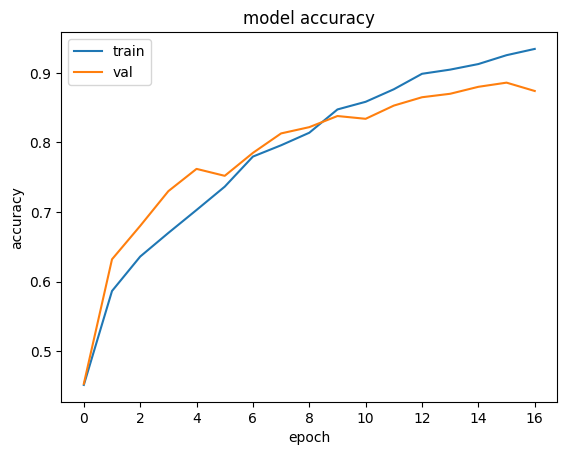

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

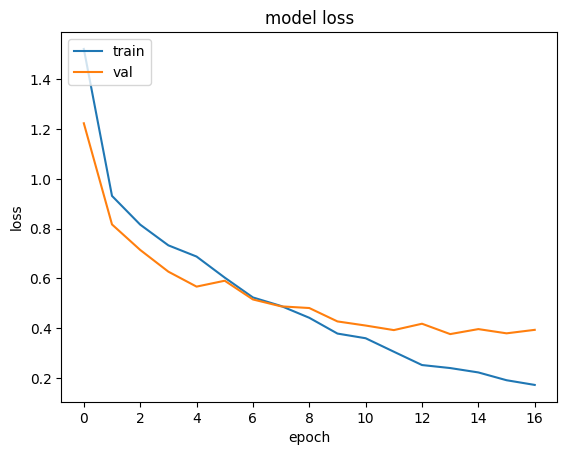

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB6_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 760ms/step
                  precision    recall  f1-score   support

    MildDemented       0.88      0.95      0.92       244
ModerateDemented       1.00      0.98      0.99       168
     NonDemented       0.85      0.90      0.87       261
VeryMildDemented       0.83      0.67      0.74       163

        accuracy                           0.89       836
       macro avg       0.89      0.88      0.88       836
    weighted avg       0.89      0.89      0.88       836

Accuracy of the Model: 88.6%


# EfficientNetB5

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB5

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB5 model without the top classification layer
base_model = EfficientNetB5(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB5_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB5_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB5_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)     │ (None, 2048)           │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,776,315 (109.77 MB)

 Trainable params: 23,225,660 (88.60 MB)

 Non-trainable params: 5,550,655 (21.17 MB)

In [ ]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [ ]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB5_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2087s 16s/step - accuracy: 0.3529 - loss: 2.4660 - val_accuracy: 0.4210 - val_loss: 1.2195 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms/step - accuracy: 0.5442 - loss: 1.0286 - val_accuracy: 0.6430 - val_loss: 0.8519 - learning_rate: 9.5000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 299ms/step - accuracy: 0.6296 - loss: 0.8597 - val_accuracy: 0.6790 - val_loss: 0.7329 - learning_rate: 9.0250e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.6619 - loss: 0.7827 - val_accuracy: 0.6930 - val_loss: 0.6598 - learning_rate: 8.5737e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 304ms/step - accuracy: 0.6773 - loss: 0.7191 - val_accuracy: 0.7400 - val_loss: 0.6270 - learning_rate: 8.1451e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - accuracy: 0.7306 - loss: 0.6315 - val_accuracy: 0.7730 - val_loss: 0.5451 - learning_rate: 7.7378e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/

In [ ]:
train_loss, train_accuracy =  EfficientNetB5_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB5_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB5_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.9643 - loss: 0.1308

Train loss: 0.12
Train Accuracy: 96.50 %
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8405 - loss: 0.3972

validation loss: 0.39
Validation Accuracy: 84.30 %
27/27 ━━━━━━━━━━━━━━━━━━━━ 267s 10s/step - accuracy: 0.9276 - loss: 0.2409

test loss: 0.37
test Accuracy: 85.89 %


In [ ]:
result = EfficientNetB5_model.evaluate(test, verbose=1)
print(result)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9276 - loss: 0.2409
[0.37314072251319885, 0.8588516712188721]


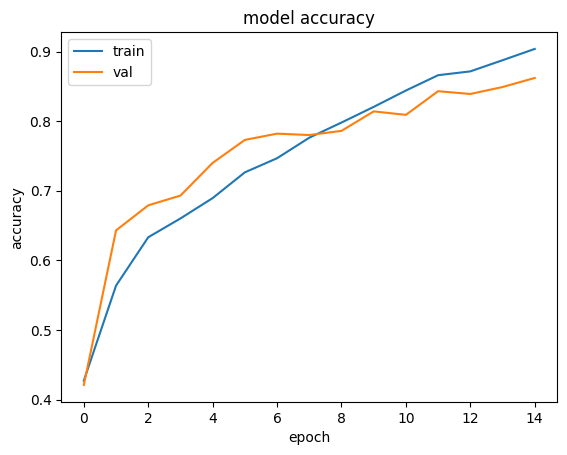

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

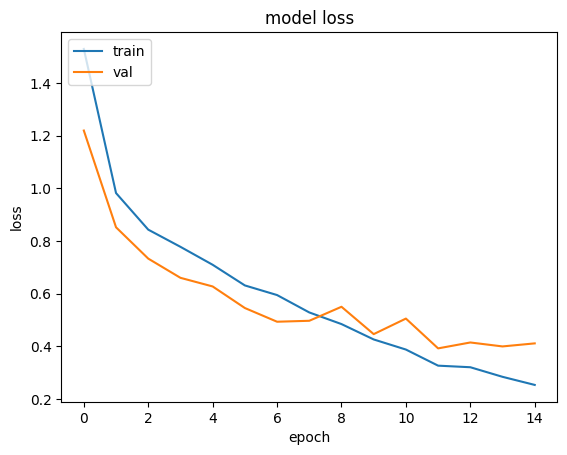

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB5_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 630ms/step
                  precision    recall  f1-score   support

    MildDemented       0.87      0.93      0.90       244
ModerateDemented       1.00      1.00      1.00       168
     NonDemented       0.82      0.85      0.83       261
VeryMildDemented       0.74      0.61      0.67       163

        accuracy                           0.86       836
       macro avg       0.86      0.85      0.85       836
    weighted avg       0.86      0.86      0.86       836

Accuracy of the Model: 85.9%


# EfficientNetB4

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB4

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB7 model without the top classification layer
base_model = EfficientNetB4(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB4_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB4_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB4_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,903,843 (68.30 MB)

 Trainable params: 14,142,652 (53.95 MB)

 Non-trainable params: 3,761,191 (14.35 MB)

In [ ]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [ ]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB4_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 157s 665ms/step - accuracy: 0.3382 - loss: 2.9240 - val_accuracy: 0.3500 - val_loss: 1.3339 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - accuracy: 0.4593 - loss: 1.1817 - val_accuracy: 0.5130 - val_loss: 1.0886 - learning_rate: 9.5000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.5347 - loss: 1.0309 - val_accuracy: 0.6290 - val_loss: 0.8786 - learning_rate: 9.0250e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.5999 - loss: 0.9227 - val_accuracy: 0.6610 - val_loss: 0.7622 - learning_rate: 8.5737e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.6288 - loss: 0.8300 - val_accuracy: 0.6490 - val_loss: 0.7875 - learning_rate: 8.1451e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.6633 - loss: 0.7716 - val_accuracy: 0.6830 - val_loss: 0.7415 - learning_rate: 7.7378e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms

In [ ]:
train_loss, train_accuracy =  EfficientNetB4_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB4_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB4_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.9344 - loss: 0.1739

Train loss: 0.17
Train Accuracy: 93.57 %
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8170 - loss: 0.4716

validation loss: 0.47
Validation Accuracy: 81.40 %
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.9227 - loss: 0.2381

test loss: 0.43
test Accuracy: 83.37 %


In [ ]:
result = EfficientNetB4_model.evaluate(test, verbose=1)
print(result)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9227 - loss: 0.2381
[0.4331471621990204, 0.8337320685386658]


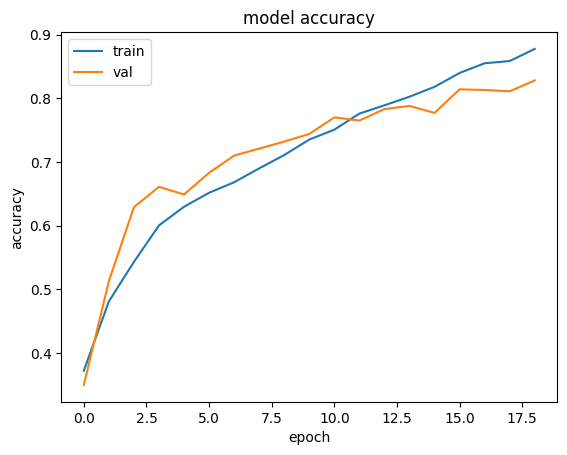

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

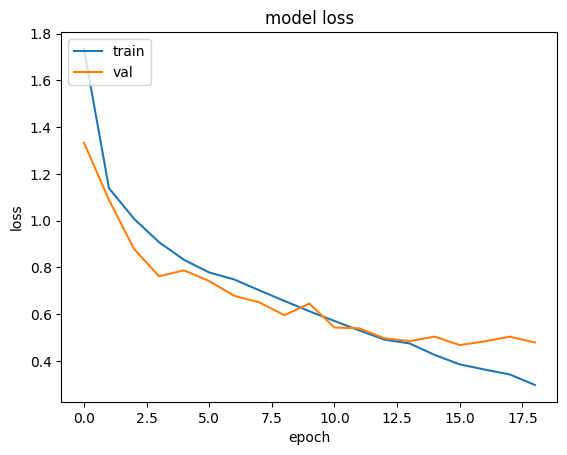

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB4_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 519ms/step
                  precision    recall  f1-score   support

    MildDemented       0.80      0.95      0.87       244
ModerateDemented       0.95      1.00      0.98       168
     NonDemented       0.82      0.84      0.83       261
VeryMildDemented       0.75      0.48      0.58       163

        accuracy                           0.83       836
       macro avg       0.83      0.82      0.82       836
    weighted avg       0.83      0.83      0.82       836

Accuracy of the Model: 83.4%


# EfficientNetB3

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB3

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB7 model without the top classification layer
base_model = EfficientNetB3(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB3_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB3_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB3_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,980,787 (41.89 MB)

 Trainable params: 8,703,330 (33.20 MB)

 Non-trainable params: 2,277,457 (8.69 MB)

In [ ]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [ ]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB3_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1611s 12s/step - accuracy: 0.3120 - loss: 2.4661 - val_accuracy: 0.3010 - val_loss: 1.3647 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.4541 - loss: 1.1938 - val_accuracy: 0.4740 - val_loss: 1.1597 - learning_rate: 9.5000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.5392 - loss: 1.0365 - val_accuracy: 0.5640 - val_loss: 0.9340 - learning_rate: 9.0250e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.5765 - loss: 0.9361 - val_accuracy: 0.6670 - val_loss: 0.7572 - learning_rate: 8.5737e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.6180 - loss: 0.8386 - val_accuracy: 0.6850 - val_loss: 0.7152 - learning_rate: 8.1451e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - accuracy: 0.6317 - loss: 0.8242 - val_accuracy: 0.6900 - val_loss: 0.7164 - learning_rate: 7.7378e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/

In [ ]:
train_loss, train_accuracy =  EfficientNetB3_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB3_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB3_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9613 - loss: 0.1009

Train loss: 0.10
Train Accuracy: 96.57 %
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8262 - loss: 0.4653

validation loss: 0.48
Validation Accuracy: 82.20 %
27/27 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - accuracy: 0.9175 - loss: 0.2465

test loss: 0.41
test Accuracy: 84.81 %


In [ ]:
result = EfficientNetB3_model.evaluate(test, verbose=1)
print(result)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9175 - loss: 0.2465
[0.40638086199760437, 0.8480861186981201]


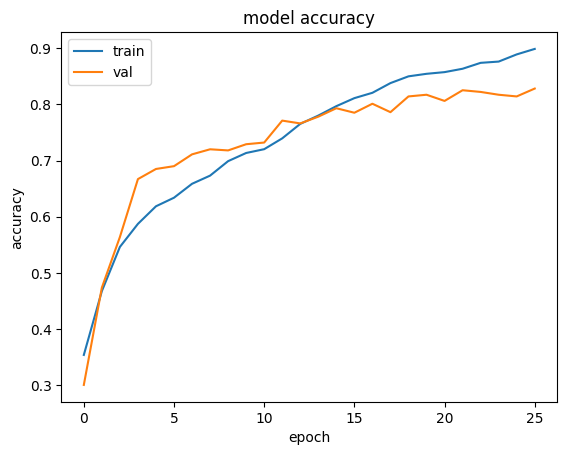

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

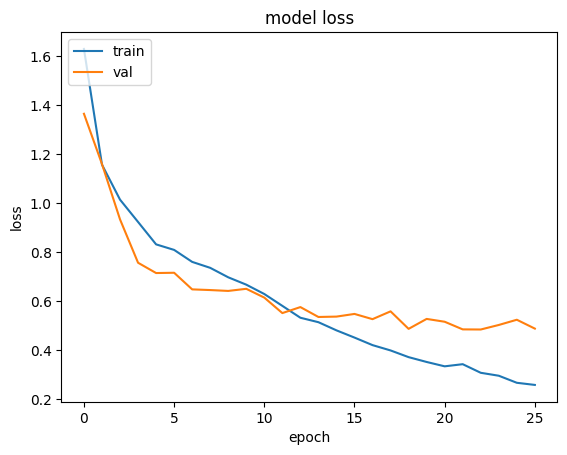

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB3_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step
                  precision    recall  f1-score   support

    MildDemented       0.85      0.93      0.89       244
ModerateDemented       0.99      0.99      0.99       168
     NonDemented       0.85      0.79      0.82       261
VeryMildDemented       0.69      0.66      0.68       163

        accuracy                           0.85       836
       macro avg       0.84      0.85      0.84       836
    weighted avg       0.85      0.85      0.85       836

Accuracy of the Model: 84.8%


# EfficientNetB2

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB2

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB2 model without the top classification layer
base_model = EfficientNetB2(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB2_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB2_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB2_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 1408)           │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,949,437 (30.32 MB)

 Trainable params: 6,463,998 (24.66 MB)

 Non-trainable params: 1,485,439 (5.67 MB)

In [ ]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [ ]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB2_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 501ms/step - accuracy: 0.2689 - loss: 3.3014 - val_accuracy: 0.2720 - val_loss: 1.3718 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.3293 - loss: 1.3666 - val_accuracy: 0.3150 - val_loss: 1.3664 - learning_rate: 9.5000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.3641 - loss: 1.3208 - val_accuracy: 0.4360 - val_loss: 1.3039 - learning_rate: 9.0250e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.4174 - loss: 1.2496 - val_accuracy: 0.4380 - val_loss: 1.1708 - learning_rate: 8.5737e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.4484 - loss: 1.2086 - val_accuracy: 0.4510 - val_loss: 1.1911 - learning_rate: 8.1451e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.4995 - loss: 1.0971 - val_accuracy: 0.4810 - val_loss: 1.1405 - learning_rate: 7.7378e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms

In [ ]:
train_loss, train_accuracy =  EfficientNetB2_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB2_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB2_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 0.6543 - loss: 0.7652

Train loss: 0.77
Train Accuracy: 64.64 %
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6361 - loss: 0.8252

validation loss: 0.82
Validation Accuracy: 62.80 %
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.6775 - loss: 0.8389

test loss: 0.81
test Accuracy: 63.52 %


In [ ]:
result = EfficientNetB2_model.evaluate(test, verbose=1)
print(result)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.6775 - loss: 0.8389
[0.81417316198349, 0.6351674795150757]


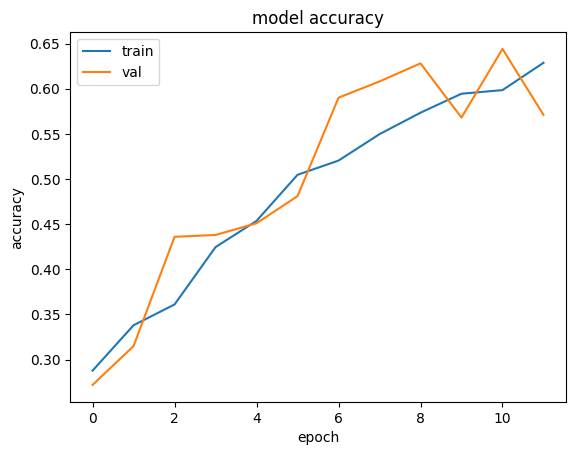

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

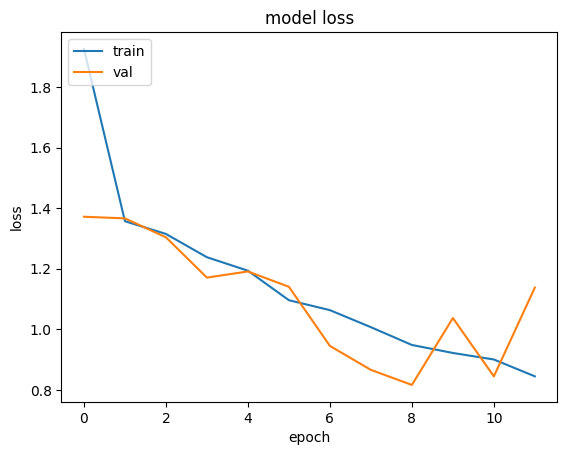

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB2_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 407ms/step
                  precision    recall  f1-score   support

    MildDemented       0.69      0.60      0.64       244
ModerateDemented       0.92      0.88      0.90       168
     NonDemented       0.51      0.89      0.65       261
VeryMildDemented       0.75      0.02      0.04       163

        accuracy                           0.64       836
       macro avg       0.72      0.60      0.56       836
    weighted avg       0.69      0.64      0.58       836

Accuracy of the Model: 63.5%


# EfficientNet B1

In [ ]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetB1

# Define input image shape
img_shape = (244, 244, 3)

# Load the pre-trained EfficientNetB1 model without the top classification layer
base_model = EfficientNetB1(
    include_top=False,         # Do not include the top classification layer
    weights="imagenet",        # Use pre-trained ImageNet weights
    input_shape=img_shape,     # Input shape
    pooling='max'              # Global max pooling after conv base
)

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True

# Flag to start fine-tuning
set_trainable = False

# Unfreeze layers from a specific point onwards
for layer in base_model.layers:
    if layer.name == 'block6a_expand_conv':  # You can change this layer to whichever layer you want to unfreeze
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
EfficientNetB1_model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape),
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

EfficientNetB1_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EfficientNetB1_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ (None, 1280)           │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,739,723 (25.71 MB)

 Trainable params: 5,471,776 (20.87 MB)

 Non-trainable params: 1,267,947 (4.84 MB)

In [ ]:
# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("GPU is available:")
    for device in physical_devices:
        print(f"  - {device}")
else:
    print("GPU is NOT available. Using CPU.")

from tensorflow.python.client import device_lib

# Print available devices
print("Available devices:")
for device in device_lib.list_local_devices():
    print(f"  - {device.name} ({device.device_type})")

GPU is available:
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Available devices:
  - /device:CPU:0 (CPU)
  - /device:GPU:0 (GPU)


In [ ]:
# Move the model to the GPU if available
with tf.device('/GPU:0'): # Or '/GPU:1' etc. if you have multiple GPUs. If no GPU, defaults to CPU.
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    history = EfficientNetB1_model.fit(
        train,
        epochs=50,
        validation_data=val,
        callbacks=[early_stopping, annealer]
    )


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 477ms/step - accuracy: 0.2705 - loss: 2.7449 - val_accuracy: 0.3140 - val_loss: 1.3729 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.3052 - loss: 1.3838 - val_accuracy: 0.2910 - val_loss: 1.3816 - learning_rate: 9.5000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.3112 - loss: 1.3775 - val_accuracy: 0.2960 - val_loss: 1.3645 - learning_rate: 9.0250e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.3222 - loss: 1.3680 - val_accuracy: 0.3260 - val_loss: 1.3523 - learning_rate: 8.5737e-04
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - accuracy: 0.3181 - loss: 1.3691 - val_accuracy: 0.3560 - val_loss: 1.3311 - learning_rate: 8.1451e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.3128 - loss: 1.3588 - val_accuracy: 0.3570 - val_loss: 1.3328 - learning_rate: 7.7378e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms

In [ ]:
train_loss, train_accuracy =  EfficientNetB1_model.evaluate(train)
print(f'\nTrain loss: {train_loss:.2f}')
print(f'Train Accuracy: {train_accuracy*100:.2f} %')

val_loss, val_accuracy =  EfficientNetB1_model.evaluate(val)
print(f'\nvalidation loss: {val_loss:.2f}')
print(f'Validation Accuracy: {val_accuracy*100:.2f} %')

test_loss, test_accuracy =  EfficientNetB1_model.evaluate(test)
print(f'\ntest loss: {test_loss:.2f}')
print(f'test Accuracy: {test_accuracy*100:.2f} %')

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.6072 - loss: 0.8916

Train loss: 0.89
Train Accuracy: 60.74 %
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.5961 - loss: 0.9260

validation loss: 0.92
Validation Accuracy: 60.20 %
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - accuracy: 0.6631 - loss: 0.8991

test loss: 0.91
test Accuracy: 60.41 %


In [ ]:
result = EfficientNetB1_model.evaluate(test, verbose=1)
print(result)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.6631 - loss: 0.8991
[0.9114353656768799, 0.6040669679641724]


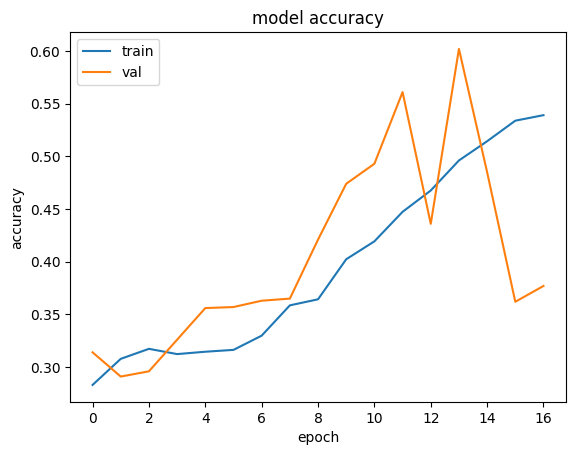

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

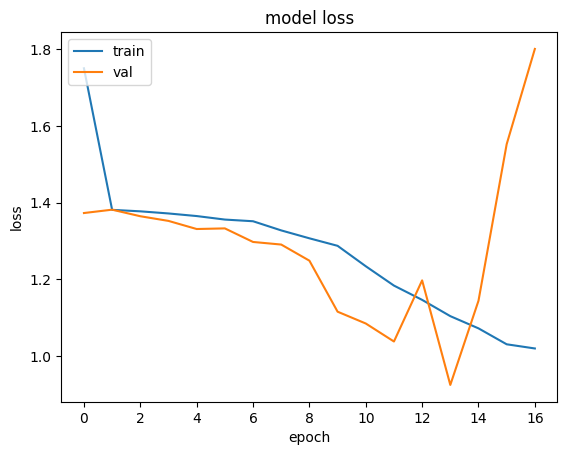

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

test_hat =  EfficientNetB1_model.predict(test)
test_hat = np.argmax(test_hat, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_report = [labels[k] for k in test_hat]

y_test = test_images.labels
print(classification_report(y_test, pred_report))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred_report)*100))

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 417ms/step
                  precision    recall  f1-score   support

    MildDemented       0.53      0.60      0.56       244
ModerateDemented       0.84      0.85      0.84       168
     NonDemented       0.56      0.83      0.66       261
VeryMildDemented       0.00      0.00      0.00       163

        accuracy                           0.60       836
       macro avg       0.48      0.57      0.52       836
    weighted avg       0.50      0.60      0.54       836

Accuracy of the Model: 60.4%
